Iniciando proceso para entrenar modelos separados para cada tarea...
Creando transformaciones de imagen...
Inicializando StanfordDogsDataset...
Preparando Stanford Dogs dataset...
StanfordDogsDataset preparado con 0 muestras.
Cargando dataset de 9Breeds...
9Breeds cargado con 1044 imágenes.
df_breed con 1044 muestras.
df_emotion con 15921 muestras.
Cargando datos de inteligencia y tamaño...
Advertencia: La columna 'intelligence' no está presente en el CSV. Se añadirá con valores NaN.
Using device: cuda
Dividiendo el dataset...
Train: 730 | Val: 209 | Test: 105
Creando BreedDataset...
BreedDataset con 730 muestras. 9 clases de raza.
Creando BreedDataset...
BreedDataset con 209 muestras. 9 clases de raza.
Creando BreedDataset...
BreedDataset con 105 muestras. 9 clases de raza.
Creando BreedClassifierResNet...
Entrenando modelo de clasificación...
Época 1/20 - Clasificación
Fin Época 1. Train Loss: 1.2999
Val Loss: 33.6740
Época 2/20 - Clasificación
Fin Época 2. Train Loss: 0.9123
Val Los

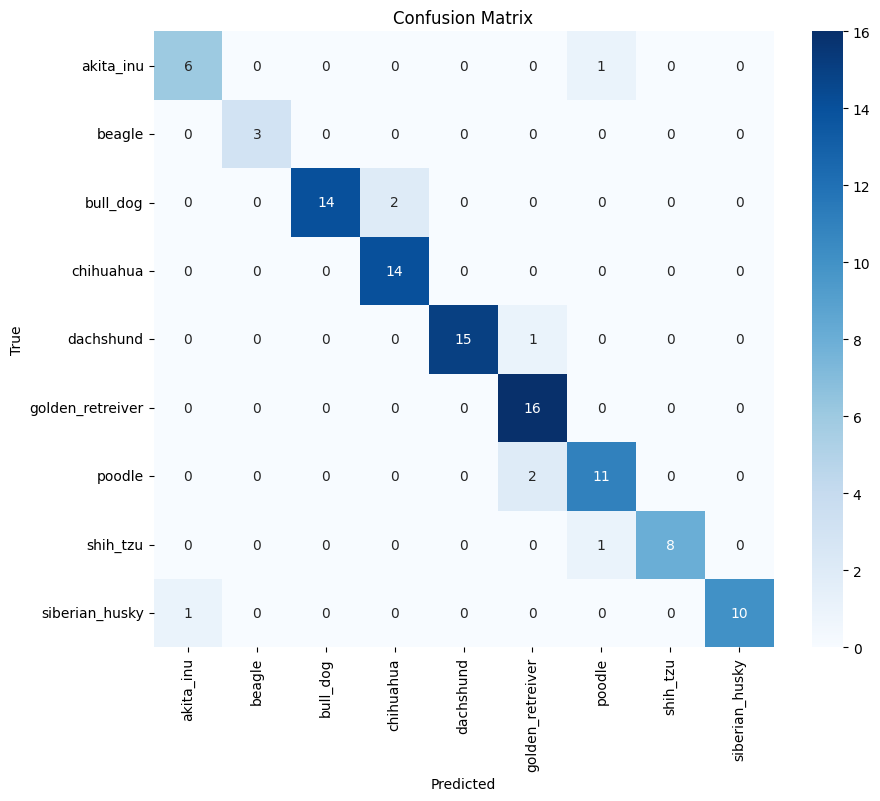

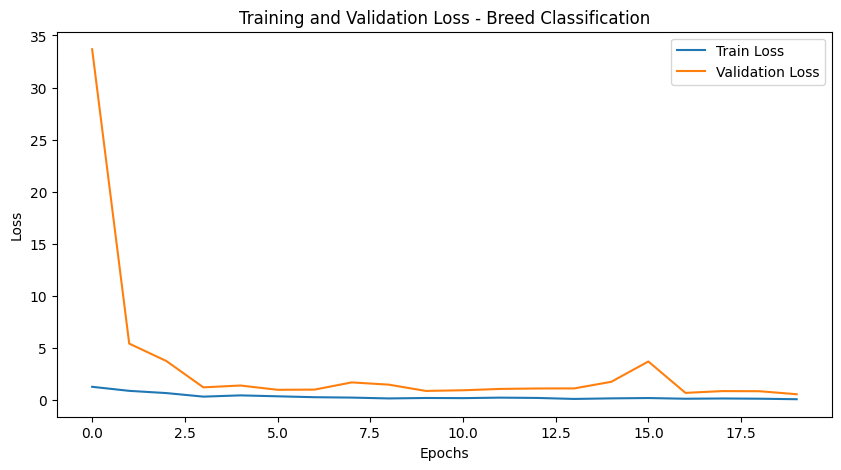

Modelo RAZAS guardado exitosamente en: models\resnet50_breed.pth
Dividiendo el dataset...
Train: 11144 | Val: 3184 | Test: 1593
Creando EmotionDataset...
EmotionDataset con 11144 muestras y 4 clases de emoción.
Creando EmotionDataset...
EmotionDataset con 3184 muestras y 4 clases de emoción.
Creando EmotionDataset...
EmotionDataset con 1593 muestras y 4 clases de emoción.
Creando EmotionClassifierResNet...
Entrenando modelo de clasificación...
Época 1/20 - Clasificación
Fin Época 1. Train Loss: 1.3231
Val Loss: 1.3415
Época 2/20 - Clasificación
Fin Época 2. Train Loss: 1.2556
Val Loss: 1.2595
Época 3/20 - Clasificación
Fin Época 3. Train Loss: 1.2547
Val Loss: 1.2202
Época 4/20 - Clasificación
Fin Época 4. Train Loss: 1.2170
Val Loss: 1.2029
Época 5/20 - Clasificación
Fin Época 5. Train Loss: 1.2045
Val Loss: 1.1950
Época 6/20 - Clasificación
Fin Época 6. Train Loss: 1.1857
Val Loss: 1.2088
Época 7/20 - Clasificación
Fin Época 7. Train Loss: 1.1807
Val Loss: 1.1745
Época 8/20 - Clasifi

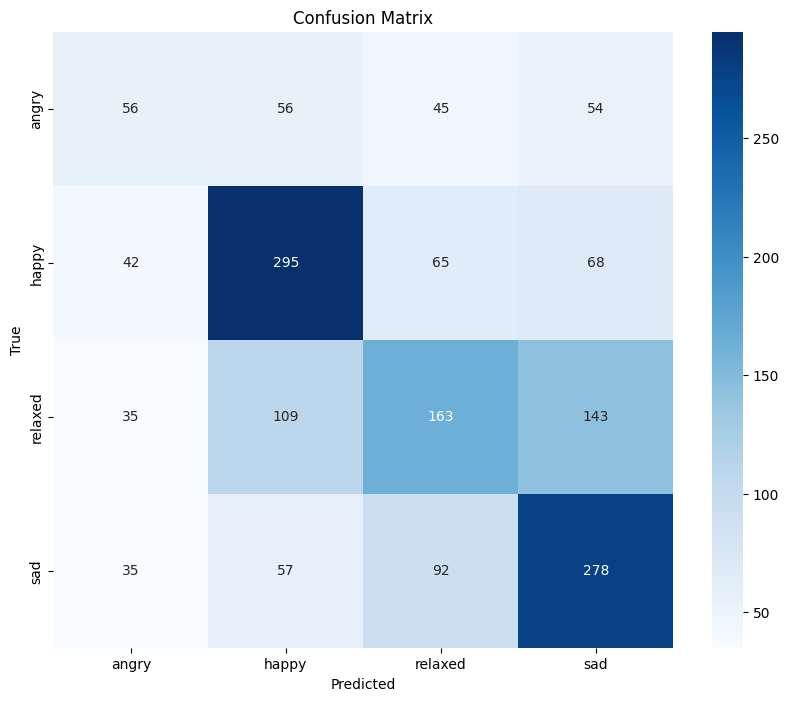

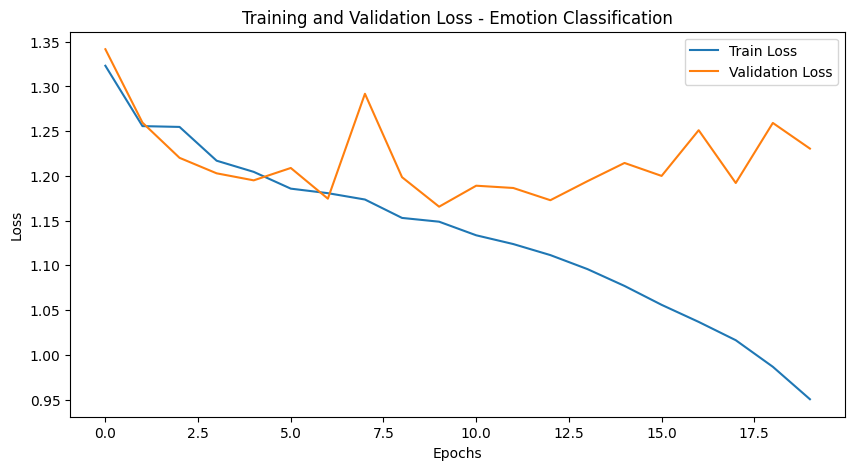

Modelo EMOCIONES guardado exitosamente en: models\resnet50_emotion.pth
Proceso finalizado. Modelos entrenados, evaluados y guardados (cuando procede).


In [2]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights

# Semilla para reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# ---------------------------------------------------------------------------
#                          CLASES DE DATASET
# ---------------------------------------------------------------------------
class StanfordDogsDataset(Dataset):
    """
    Carga el dataset de Stanford Dogs revisando únicamente la existencia de
    archivo de anotación .xml (sin parsearlo) para filtrar imágenes válidas.
    """
    def __init__(self, images_dir, annotations_dir, transform=None):
        print("Inicializando StanfordDogsDataset...")
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(images_dir, '*', '*.jpg'))
        self.labels = []
        self._prepare_dataset()

    def _prepare_dataset(self):
        print("Preparando Stanford Dogs dataset...")
        self.data = []
        for img_path in self.image_paths:
            breed = os.path.basename(os.path.dirname(img_path))
            image_name = os.path.basename(img_path).split('.')[0]
            annotation_file = os.path.join(self.annotations_dir, breed, f"{image_name}.xml")
            if not os.path.exists(annotation_file):
                continue
            self.data.append((img_path, breed))
            self.labels.append(breed)
        print(f"StanfordDogsDataset preparado con {len(self.data)} muestras.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


class BreedDataset(Dataset):
    """
    Dataset para clasificación de razas.
    """
    def __init__(self, dataframe, transform=None):
        print("Creando BreedDataset...")
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.breed_set = sorted(set(self.dataframe['Breed'].dropna()))
        self.breed_to_idx = {breed: idx for idx, breed in enumerate(self.breed_set)}
        self.idx_to_breed = {idx: breed for breed, idx in self.breed_to_idx.items()}
        print(f"BreedDataset con {len(self.dataframe)} muestras. {len(self.breed_set)} clases de raza.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        breed_label = self.breed_to_idx.get(row['Breed'], -1)
        return image, breed_label


class EmotionDataset(Dataset):
    """
    Dataset para clasificación de emociones (etiqueta única).
    """
    def __init__(self, dataframe, transform=None):
        print("Creando EmotionDataset...")
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        # Solo filas con 'Emotion' no nulo
        self.dataframe = self.dataframe[self.dataframe['Emotion'].notna()].reset_index(drop=True)
        self.emotion_set = sorted(set(self.dataframe['Emotion'].dropna()))
        self.emotion_to_idx = {emotion: idx for idx, emotion in enumerate(self.emotion_set)}
        self.idx_to_emotion = {idx: emotion for emotion, idx in self.emotion_to_idx.items()}
        print(f"EmotionDataset con {len(self.dataframe)} muestras y {len(self.emotion_set)} clases de emoción.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        emotion_label = self.emotion_to_idx.get(row['Emotion'], -1)
        return image, emotion_label

# ---------------------------------------------------------------------------
#                          FUNCIONES AUXILIARES
# ---------------------------------------------------------------------------
def load_nine_breeds_dog_breeds(nine_breeds_path, transform=None):
    print("Cargando dataset de 9Breeds...")
    dataset = datasets.ImageFolder(root=nine_breeds_path, transform=transform)
    print(f"9Breeds cargado con {len(dataset.samples)} imágenes.")
    return dataset



def get_transforms():
    print("Creando transformaciones de imagen...")
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


def split_dataset(df, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=SEED):
    print("Dividiendo el dataset...")
    train_df, temp_df = train_test_split(df, train_size=train_ratio, random_state=seed)
    val_size = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(temp_df, train_size=val_size, random_state=seed)
    print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

# ---------------------------------------------------------------------------
#                          MODELOS
# ---------------------------------------------------------------------------
class BreedClassifierResNet(nn.Module):
    def __init__(self, num_breeds):
        super(BreedClassifierResNet, self).__init__()
        print("Creando BreedClassifierResNet...")
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_breeds)

    def forward(self, x):
        return self.resnet(x)


class EmotionClassifierResNet(nn.Module):
    def __init__(self, num_emotions):
        super(EmotionClassifierResNet, self).__init__()
        print("Creando EmotionClassifierResNet...")
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_emotions)

    def forward(self, x):
        return self.resnet(x)

# ---------------------------------------------------------------------------
#               FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# ---------------------------------------------------------------------------
def train_classification_model(model, train_loader, val_loader, class_names, device='cuda', epochs=10):
    """
    Entrena un modelo de clasificación (razas o emociones) con CrossEntropyLoss.
    """
    print("Entrenando modelo de clasificación...")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        print(f"Época {epoch+1}/{epochs} - Clasificación")
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Fin Época {epoch+1}. Train Loss: {avg_train_loss:.4f}")

        # Validación
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Val Loss: {avg_val_loss:.4f}")
    return train_losses, val_losses

def evaluate_classification_model(model, test_loader, class_names, device='cuda'):
    """
    Evalúa un modelo de clasificación mostrando el reporte de clasificación y la matriz de confusión.
    """
    print("Evaluando modelo de clasificación...")
    model.to(device)
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(predicted)
            true_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(true_labels, preds, target_names=class_names))

    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_losses(train_losses, val_losses, title):
    """
    Grafica las curvas de pérdida de entrenamiento y validación.
    """
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

# ---------------------------------------------------------------------------
#                                MAIN
# ---------------------------------------------------------------------------
def main():
    print("Iniciando proceso para entrenar modelos separados para cada tarea...")

    # Directorios y rutas de interés
    stanford_images_path = './datasets/stanford_breeds/Images'
    stanford_annotations_path = './datasets/stanford_breeds/Annotation'
    nine_breeds_path = './datasets/9Breeds'
    emotion_path = './datasets/dogs_emotions'

    # Transformaciones de imagen
    transform = get_transforms()

    # Crear carpeta para guardar modelos
    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)

    # Cargar Stanford Dogs (sin transform)
    stanford_dataset = StanfordDogsDataset(stanford_images_path, stanford_annotations_path, transform=None)

    # Cargar dataset de 9Breeds (sin transform)
    nine_breeds_dataset = load_nine_breeds_dog_breeds(nine_breeds_path, transform=None)

    # Cargar dataset de emociones
    emotion_dataset = datasets.ImageFolder(root=emotion_path)

    # DataFrame para razas (Stanford + 9Breeds)
    breed_images = [img_path for img_path, _ in stanford_dataset.data] \
                   + [path for path, _ in nine_breeds_dataset.samples]
    breed_labels = stanford_dataset.labels \
                   + [nine_breeds_dataset.classes[label] for _, label in nine_breeds_dataset.samples]

    # Normalizar paths y nombres de razas
    breed_images = [os.path.normpath(path) for path in breed_images]
    breed_labels_clean = []
    for b in breed_labels:
        # Limpiar: minúscula, underscores, etc.
        b_clean = b.lower().replace('-', '_').replace(' ', '_')
        breed_labels_clean.append(b_clean)

    df_breed = pd.DataFrame({'image': breed_images, 'Breed': breed_labels_clean})
    print(f"df_breed con {len(df_breed)} muestras.")

    # DataFrame para emociones
    emotion_images = [os.path.normpath(path) for path, _ in emotion_dataset.samples]
    emotion_labels_raw = [emotion_dataset.classes[label] for _, label in emotion_dataset.samples]
    emotion_labels_clean = []
    for e in emotion_labels_raw:
        # Ejemplo: Normalizar nombres de emoción (si se requiere)
        e_clean = e.lower().replace(' ', '_')
        emotion_labels_clean.append(e_clean)

    df_emotion = pd.DataFrame({'image': emotion_images, 'Emotion': emotion_labels_clean})
    print(f"df_emotion con {len(df_emotion)} muestras.")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # -----------------------------------------------------------------------
    # 1) MODELO RAZAS
    # -----------------------------------------------------------------------
    train_df_breed, val_df_breed, test_df_breed = split_dataset(
        df_breed,
        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,
        seed=SEED
    )
    train_dataset_breed = BreedDataset(train_df_breed, transform=transform)
    val_dataset_breed = BreedDataset(val_df_breed, transform=transform)
    test_dataset_breed = BreedDataset(test_df_breed, transform=transform)

    train_loader_breed = DataLoader(train_dataset_breed, batch_size=32, shuffle=True, num_workers=0)
    val_loader_breed = DataLoader(val_dataset_breed, batch_size=32, shuffle=False, num_workers=0)
    test_loader_breed = DataLoader(test_dataset_breed, batch_size=32, shuffle=False, num_workers=0)

    model_breed = BreedClassifierResNet(num_breeds=len(train_dataset_breed.breed_set))

    breed_train_losses, breed_val_losses = train_classification_model(
        model_breed, train_loader_breed, val_loader_breed,
        class_names=train_dataset_breed.breed_set, device=device, epochs=20  
    )

    evaluate_classification_model(
        model_breed, test_loader_breed,
        class_names=train_dataset_breed.breed_set, device=device
    )

    plot_losses(breed_train_losses, breed_val_losses,
                'Training and Validation Loss - Breed Classification'
                )
    
    try:
        model_breed_path = os.path.join(model_dir, "resnet50_breed.pth")
        torch.save(model_breed.state_dict(), model_breed_path)
        print(f"Modelo RAZAS guardado exitosamente en: {model_breed_path}")
    except Exception as e:
        print(f"Error al guardar el modelo RAZAS: {e}")

    # -----------------------------------------------------------------------
    # 2) MODELO EMOCIONES
    # -----------------------------------------------------------------------

    if len(df_emotion) < 1:
        print("No hay datos de emociones disponibles para entrenar el modelo de emociones.")
    else:
        train_df_emo, val_df_emo, test_df_emo = split_dataset(
            df_emotion,
            train_ratio=0.7,
            val_ratio=0.2,
            test_ratio=0.1,
            seed=SEED
        )
        train_dataset_emo = EmotionDataset(train_df_emo, transform=transform)
        val_dataset_emo = EmotionDataset(val_df_emo, transform=transform)
        test_dataset_emo = EmotionDataset(test_df_emo, transform=transform)

        train_loader_emo = DataLoader(train_dataset_emo, batch_size=32, shuffle=True, num_workers=0)
        val_loader_emo = DataLoader(val_dataset_emo, batch_size=32, shuffle=False, num_workers=0)
        test_loader_emo = DataLoader(test_dataset_emo, batch_size=32, shuffle=False, num_workers=0)

        model_emo = EmotionClassifierResNet(num_emotions=len(train_dataset_emo.emotion_set))

        emo_train_losses, emo_val_losses = train_classification_model(
            model_emo, train_loader_emo, val_loader_emo,
            class_names=train_dataset_emo.emotion_set, device=device, epochs=20
        )

        evaluate_classification_model(
            model_emo, test_loader_emo,
            class_names=train_dataset_emo.emotion_set, device=device
        )

        plot_losses(emo_train_losses, emo_val_losses,
                    'Training and Validation Loss - Emotion Classification')

        try:
            emotion_model_path = os.path.join(model_dir, "resnet50_emotion.pth")
            torch.save(model_emo.state_dict(), emotion_model_path)
            print(f"Modelo EMOCIONES guardado exitosamente en: {emotion_model_path}")
        except Exception as e:
            print(f"Error al guardar el modelo EMOCIONES: {e}")


    print("Proceso finalizado. Modelos entrenados, evaluados y guardados (cuando procede).")

# ---------------------------------------------------------------------------
#                        EJECUCIÓN PRINCIPAL
# ---------------------------------------------------------------------------
if __name__ == '__main__':
    main()
